<a href="https://colab.research.google.com/github/terrysu64/9anime-Ad-Blocker/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - fine-tuning

In [ ]:
!nvidia-smi

Mon Aug  8 19:57:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### import helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-08 19:57:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-08 19:57:54 (64.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### get data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-08 19:57:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  54.4MB/s    in 3.0s    

2022-08-08 19:58:00 (54.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (225,225); BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data, train_data.class_names

(<BatchDataset element_spec=(TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [ ]:
#visualize a batch
for imgs, labels in train_data.take(1):
  print(imgs, labels)

tf.Tensor(
[[[[154.08182    179.08182    233.08182   ]
   [152.91333    177.91333    231.91333   ]
   [154.39719    179.39719    233.39719   ]
   ...
   [ 47.977844    50.977844    67.400085  ]
   [ 40.49899     44.072323    57.35232   ]
   [ 35.828045    39.828045    49.25468   ]]

  [[168.22       195.22       248.22      ]
   [167.8303     194.8303     247.8303    ]
   [166.59557    193.59557    246.59557   ]
   ...
   [ 49.276825    52.276825    67.276825  ]
   [ 40.18302     43.756355    57.036354  ]
   [ 33.649044    40.22241     50.506832  ]]

  [[171.5008     199.06746    253.87857   ]
   [170.16785    197.73451    252.54562   ]
   [169.81111    197.37778    252.18889   ]
   ...
   [ 51.078796    56.61017     70.03241   ]
   [ 44.084293    49.392147    61.392147  ]
   [ 36.973488    45.546852    54.973488  ]]

  ...

  [[ 14.264296    18.264296    20.886549  ]
   [ 13.75176     17.510002    20.212841  ]
   [ 15.413111    18.84649     21.657618  ]
   ...
   [ 22.367558    30.133

### experiment 1: pure feature extraction + data augmentation

In [35]:
from tensorflow.keras.layers.experimental import preprocessing as pre #augments on gpu and only during train
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import os

data_aug = tf.keras.Sequential([
    pre.RandomFlip("horizontal"),
    pre.RandomRotation(0.2),
    pre.RandomZoom(0.2)
], name="data_augmentation")

target_class = random.choice(train_data.class_names)
target_dir = ''.join([train_dir,'/',target_class])
img = ''.join([target_dir,
               '/',
               random.choice(os.listdir(target_dir))])

aug_img = data_aug(mpimg.imread(img))
plt.title('augmented random image')
plt.imshow(aug_img/255)

AttributeError: ignored

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE)+(3,), name="input_layer") #normalizing not needed for efficientnet
#x = data_aug(inputs, training=True)
x = base_model(inputs)
print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
print(x.shape)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
(None, 7, 7, 1280)
(None, 1280)


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
#model checkpoint callback
save_path = "model_checkpoints/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    callbacks=[checkpoint_callback,
                               create_tensorboard_callback(dir_name="models",
                                                           experiment_name="feature_extraction")])

Saving TensorBoard log files to: models/feature_extraction/20220808-195815
Epoch 1/3
24/24 [==============================] - ETA: 0s - loss: 1.8612 - accuracy: 0.4333
Epoch 1: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 23s 273ms/step - loss: 1.8612 - accuracy: 0.4333 - val_loss: 1.3086 - val_accuracy: 0.7220
Epoch 2/3
23/24 [===========================>..] - ETA: 0s - loss: 1.1188 - accuracy: 0.7473
Epoch 2: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 5s 195ms/step - loss: 1.1144 - accuracy: 0.7480 - val_loss: 0.9118 - val_accuracy: 0.8026
Epoch 3/3
23/24 [===========================>..] - ETA: 0s - loss: 0.8260 - accuracy: 0.8125
Epoch 3: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 160ms/step - loss: 0.8245 - accuracy: 0.8120 - val_loss: 0.7282 - val_accuracy: 0.8339


In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 0.7490 - accuracy: 0.8244


[0.7489511370658875, 0.824400007724762]

In [ ]:
for i,layer in enumerate(base_model.layers): print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

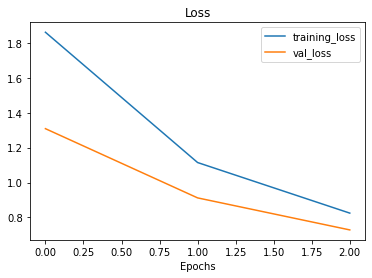

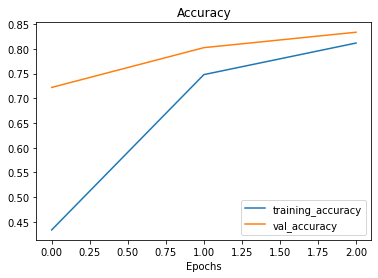

In [ ]:
plot_loss_curves(history)

### getting a feature vector

In [ ]:
#globalavgpool2d compresses 4-d to 2-d via averaging middle 2 axis to make a feature vector

tf.random.set_seed(42)

input_shape = (1,4,4,3)
tensor = tf.random.normal(input_shape)

pooled_tensor = tf.keras.layers.GlobalAvgPool2D()(tensor)
tensor.shape,pooled_tensor.shape


(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

### loading checkpoints and weights

In [ ]:
#load and evaluate

model.load_weights(save_path)

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 7s 72ms/step - loss: 0.7490 - accuracy: 0.8244


[0.7489514350891113, 0.824400007724762]

### experiment 2: fine-tuning 

**note**: usually works best after training for a few epochs fist

In [ ]:
model.layers

In [ ]:
[(layer,layer.trainable )for layer in model.layers[1].layers] #layers in borrowed model

[(<keras.engine.input_layer.InputLayer at 0x7f65388fbe10>, False),
 (<keras.layers.preprocessing.image_preprocessing.Rescaling at 0x7f653a0497d0>,
  False),
 (<keras.layers.preprocessing.normalization.Normalization at 0x7f653894e990>,
  False),
 (<keras.layers.convolutional.ZeroPadding2D at 0x7f6538908d90>, False),
 (<keras.layers.convolutional.Conv2D at 0x7f653893fbd0>, False),
 (<keras.layers.normalization.batch_normalization.BatchNormalization at 0x7f65389239d0>,
  False),
 (<keras.layers.core.activation.Activation at 0x7f6538954cd0>, False),
 (<keras.layers.convolutional.DepthwiseConv2D at 0x7f653897af90>, False),
 (<keras.layers.normalization.batch_normalization.BatchNormalization at 0x7f6538936710>,
  False),
 (<keras.layers.core.activation.Activation at 0x7f653a0079d0>, False),
 (<keras.layers.pooling.GlobalAveragePooling2D at 0x7f65200c36d0>, False),
 (<keras.layers.core.reshape.Reshape at 0x7f65200c33d0>, False),
 (<keras.layers.convolutional.Conv2D at 0x7f6520139450>, False),

In [ ]:
#unfreeze last 10 layers

base_model.trainable = True
for layer in base_model.layers[:-10]: layer.trainable=False



In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #rule of thumb is to lower lr for fine-tuning
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)

12

In [ ]:
history = model.fit(train_data,
                    epochs=3+5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    initial_epoch=history.epoch[-1], #start training where last model left off
                    callbacks=[checkpoint_callback,
                               create_tensorboard_callback(dir_name="models",
                                                           experiment_name="fine_tuning")])

Saving TensorBoard log files to: models/fine_tuning/20220808-195906
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.8107
Epoch 3: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 16s 370ms/step - loss: 0.7867 - accuracy: 0.8107 - val_loss: 0.6161 - val_accuracy: 0.8520
Epoch 4/8
23/24 [===========================>..] - ETA: 0s - loss: 0.5987 - accuracy: 0.8560
Epoch 4: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 167ms/step - loss: 0.6010 - accuracy: 0.8547 - val_loss: 0.5197 - val_accuracy: 0.8586
Epoch 5/8
23/24 [===========================>..] - ETA: 0s - loss: 0.5113 - accuracy: 0.8886
Epoch 5: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 163ms/step - loss: 0.5092 - accuracy: 0.8907 - val_loss: 0.5406 - val_accuracy: 0.8405
Epoch 6/8
23/24 [===========================>..] - ETA: 0s - loss: 0.4420 - accura

In [ ]:
results = model.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4673 - accuracy: 0.8548


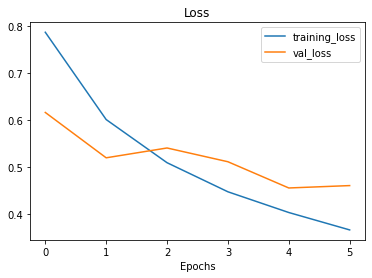

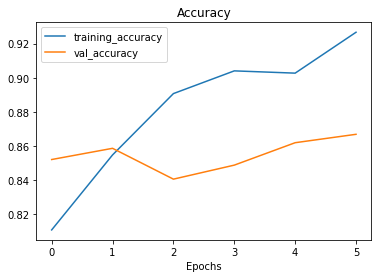

In [ ]:
plot_loss_curves(history) #need to reduce overfitting

In [ ]:
#can revert back the fine tuning via loading the checkpoint weights

### Investingating incorrect predictions

In [37]:
preds = model.predict(test_data)

#get filepaths
filepaths = []
for filepath in test_data.list_files("/content/10_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths += [filepath.numpy()]

filepaths[:5]

[b'/content/10_food_classes_10_percent/test/chicken_curry/101833.jpg',
 b'/content/10_food_classes_10_percent/test/chicken_curry/10340.jpg',
 b'/content/10_food_classes_10_percent/test/chicken_curry/1035626.jpg',
 b'/content/10_food_classes_10_percent/test/chicken_curry/1048226.jpg',
 b'/content/10_food_classes_10_percent/test/chicken_curry/1075859.jpg']

In [47]:
import pandas as pd

#group test vs pred labels together

y_labels = []

for images, labels in test_data.unbatch(): 
  y_labels.append(labels.numpy().argmax()) 


pred_classes = preds.argmax(axis=1)

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds.max(axis=1)})

In [48]:
pred_df 

,img_path,y_true,y_pred,pred_conf
0,b'/content/10_food_classes_10_percent/test/chi...,8,0,0.303116
1,b'/content/10_food_classes_10_percent/test/chi...,1,5,0.650159
2,b'/content/10_food_classes_10_percent/test/chi...,5,5,0.868459
3,b'/content/10_food_classes_10_percent/test/chi...,3,6,0.992494
4,b'/content/10_food_classes_10_percent/test/chi...,6,3,0.839004
...,...,...,...,...
2495,b'/content/10_food_classes_10_percent/test/sus...,9,7,0.806772
2496,b'/content/10_food_classes_10_percent/test/sus...,2,5,0.989764
2497,b'/content/10_food_classes_10_percent/test/sus...,8,7,0.977295
2498,b'/content/10_food_classes_10_percent/test/sus...,8,0,0.973780


In [53]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.sort_values('pred_correct', ascending=False) #we could further sort to find specific images that had a high confidence but was incorrect

,img_path,y_true,y_pred,pred_conf,pred_correct
1317,b'/content/10_food_classes_10_percent/test/ice...,7,7,0.952363,True
1995,b'/content/10_food_classes_10_percent/test/ram...,4,4,0.508128,True
247,b'/content/10_food_classes_10_percent/test/chi...,5,5,0.920422,True
1993,b'/content/10_food_classes_10_percent/test/ram...,5,5,0.961611,True
1739,b'/content/10_food_classes_10_percent/test/piz...,4,4,0.874010,True
...,...,...,...,...,...
882,b'/content/10_food_classes_10_percent/test/gri...,9,3,0.555777,False
883,b'/content/10_food_classes_10_percent/test/gri...,1,6,0.442284,False
884,b'/content/10_food_classes_10_percent/test/gri...,7,2,0.871278,False
885,b'/content/10_food_classes_10_percent/test/gri...,0,1,0.988663,False
